In [1]:
import json
import re
import sys
import pandas as pd
import numpy as np

## Preprocessing

In [2]:
import dataloader

In [3]:
train_df = dataloader.load_data(data_file = '../data/train.data.jsonl', label_file = '../data/train.label.json', perform_stemming = False)
dev_df = dataloader.load_data(data_file = '../data/dev.data.jsonl', label_file = '../data/dev.label.json', perform_stemming = False)
test_df = dataloader.load_data(data_file = '../data/test.data.jsonl', label_file = None, perform_stemming = False)

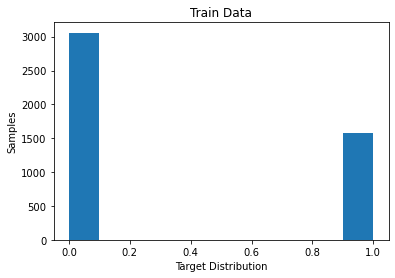

In [4]:
import matplotlib.pyplot as plt
plt.title('Train Data')
plt.xlabel('Target Distribution')
plt.ylabel('Samples')
plt.hist(train_df.label)
plt.show()

In [5]:
combined_df = train_df.append(dev_df, ignore_index = True)
combined_df

,id,text,retweet_count,favorite_count,question_mark,contains_url,number_urls,contains_media,statuses_count,listed_count,...,reputation_score_2,favourites_count,verified,geo_enabled,has_description,length_description,source_tweet,replies,hashtags,label
0,552800070199148544,how to respond to the murderous attack on char...,228,77,True,False,0,True,27923,185,...,0.908971,500,False,False,True,46,how to respond to the murderous attack on char...,[jews label anyone they do not like as anti se...,[imcharliehebdo],0
1,544388259359387648,you can not condemn an entire race nation or ...,352,252,False,False,0,False,745,2,...,0.413158,428,False,False,True,115,you can not condemn an entire race nation or ...,[how many times are we going to have the do n...,"[sydneysiege, sydneysiege, leftistluzer, sydne...",0
2,552805970536333314,attempts to extend blame for this to all musli...,876,400,False,False,0,False,74137,1431,...,0.954630,6423,False,True,True,149,attempts to extend blame for this to all musli...,[when will we see mass protests from amoderat...,"[charliehebdo, nonmuslimlivesmatter]",0
3,525071376084791297,rest in peace cpl nathan cirillo killed tod...,112,96,False,True,1,True,28103,418,...,0.933548,2140,True,True,True,157,rest in peace cpl nathan cirillo killed tod...,"[hot guy, hey frizz i was right downtown crazy...","[ottawashooting, ottawashooting, ottawashootin...",1
4,498355319979143168,people debating whether mikebrown shoplifted o...,802,298,False,False,0,False,55920,65,...,0.678947,25389,False,False,True,156,people debating whether mikebrown shoplifted o...,[yeah and shooting him times while not even...,"[mikebrown, ferguson, mikebrown, mikebrown, mi...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5216,525025279803424768,the soldier shot dead in wednesday is ottawa a...,119,36,False,False,0,True,88483,306,...,0.727071,1903,True,True,True,101,the soldier shot dead in wednesday is ottawa a...,"[my condolences go out to your family, that ...","[hamont, ottawashooting, notinvain]",1
5217,552784600502915072,charlie hebdo became well known for publishing...,202,41,False,False,0,False,15128,1657,...,0.948267,0,True,True,True,158,charlie hebdo became well known for publishing...,[i am muslim would you call me violent even ...,[islamphobiaatitsbest],0
5218,499696525808001024,we got through that is a sniper on top of a t...,432,55,False,True,1,False,61902,1627,...,0.982027,1163,False,True,True,159,we got through that is a sniper on top of a t...,[we got through that is a sniper on top of a ...,"[ferguson, ferguson, ferguson, responsiblejour...",0
5219,580320612155060224,last position of germanwings flight u at ...,3092,480,False,True,1,True,7991,2384,...,0.998276,1131,True,True,True,146,last position of germanwings flight u at ...,[where was the pilot how come he did not use ...,"[4u9525, 4u9525, 4u9525, 4u9525, 4u9525, 4u952...",1


In [6]:
combined_df['text'][5]

'update   pa  gunman holding hostages in paris grocery has been killed wish we would been as decisive with the lee rigby killers rot in hell update   pa  gunman holding hostages in paris grocery has been killed good surely you mean islamist terrorist not gunman good shoot them all paris will mourn forever any news on the woman hostage taker thank fuck for that get in  fucking lunatic prick update   pa  gunman holding hostages in paris grocery has been killed  tangodown them all  there was two amen to that well done   best way to deal with the scum hope he fucking rots in hell good great result     no messing french love em   we would still be fucking around if happened here   pc begrade  rule the uk i hope it was very painful   rot in hell good  hope he she rots in hell sending thoughts to the victims and hostages at this awful time evil bastards any news on the hostages or what  dont care about the terrorists'

## Text-only BERT (Tensorflow)

## Loading BertTokenizer

Load tokenizer (allows to switch between Roberta and BERT)

In [16]:
from transformers import RobertaTokenizer
from transformers import BertTokenizer


tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [17]:
import numpy as np
import tensorflow as tf 

## BERT encoding

Data is encoded according to BERT requirement.

* Tokenize the text
* Add special tokens - [CLS] and [SEP]
* Pad the sentences to a common length
* Create attention masks for the above PAD tokens

In [18]:
def bert_encode(data,maximum_length) :
    input_ids = []
    attention_masks = []


    for i in range(len(data.text)):
        encoded = tokenizer.encode_plus(
            data.text[i],
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation = True

        )

        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

Input are 2 Numpy array. Let me briefly go over them:

1) input_ids : list of token ids to be fed to a model

2) attention_masks: list of indices specifying which tokens should be attended to by the model.The input sequences are denoted by 1 and the padded ones by 0. These masks help to differentiate between the two.

In [19]:
combined_input_ids,combined_attention_masks = bert_encode(combined_df,512)
test_input_ids,test_attention_masks = bert_encode(test_df,512)

In [20]:
combined_input_ids

array([[    0,  9178,     7, ...,     1,     1,     1],
       [    0,  6968,    64, ...,  1437,    16,     2],
       [    0,  2611, 15318, ...,     1,     1,     1],
       ...,
       [    0,  1694,   300, ...,   939,   450,     2],
       [    0, 13751,   737, ...,    10,  6485,     2],
       [    0,   330, 30729, ...,     1,     1,     1]])

In [21]:
len(combined_input_ids)

5221

## Creating Custom Model

Base TFBert Model with Dense layer and sigmoid activation as head.

In [22]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam

def create_model(bert_model):
    input_ids = tf.keras.Input(shape=(512,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(512,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)

    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

## TFBertModel

The bare Bert Model transformer outputing raw hidden-states without any specific head on top. https://huggingface.co/transformers/model_doc/bert.html#tfbertmodel

In [26]:
from transformers import TFBertModel
from transformers import TFRobertaModel

bert_model = TFRobertaModel.from_pretrained('roberta-base')

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


## Implementing custom model

In [27]:
model = create_model(bert_model)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model_2 (TFRobertaMo TFBaseModelOutputWit 124645632   input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 32)           24608       tf_roberta_model_2[0][1]   

## Training

Fit for 5 epochs:

In [28]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit([combined_input_ids,combined_attention_masks],combined_df.label,validation_split=0.001,callbacks=[callback], epochs=7,batch_size=2)

Epoch 1/7
2608/2608 [==============================] - 1345s 509ms/step - loss: 0.5208 - accuracy: 0.7447 - val_loss: 0.3061 - val_accuracy: 0.8333
Epoch 2/7
2608/2608 [==============================] - 1326s 509ms/step - loss: 0.3236 - accuracy: 0.8717 - val_loss: 0.5347 - val_accuracy: 0.8333
Epoch 3/7
2608/2608 [==============================] - 1326s 508ms/step - loss: 0.2212 - accuracy: 0.9127 - val_loss: 0.7349 - val_accuracy: 0.8333
Epoch 4/7
2608/2608 [==============================] - 1327s 509ms/step - loss: 0.1668 - accuracy: 0.9352 - val_loss: 0.9799 - val_accuracy: 0.8333
Epoch 5/7
2608/2608 [==============================] - 1326s 508ms/step - loss: 0.1032 - accuracy: 0.9624 - val_loss: 1.3735 - val_accuracy: 0.6667
Epoch 6/7
 788/2608 [========>.....................] - ETA: 15:24 - loss: 0.0558 - accuracy: 0.9826

KeyboardInterrupt: 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', color = "red", label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', color="red", label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


plt.show()

In [29]:
model.save("./roberta/roberta_v36")

IndexError: list index out of range

## Testing

In [33]:
result = model.predict([test_input_ids,])



ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:207 assert_input_compatibility
        ' input tensors. Inputs received: ' + str(inputs))

    ValueError: Layer model_1 expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 512) dtype=int64>]


In [30]:
result = model.predict([test_input_ids,test_attention_masks])
result = np.round(result).astype(int)
predicted_labels = [dataloader.convert_prediction(pred) for pred in result]
output = pd.DataFrame({'id':test_df.id,'target':predicted_labels})
output

StagingError: in user code:

    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:425 call
        inputs, training=training, mask=mask)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/saving/saved_model/utils.py:73 return_outputs_and_add_losses
        outputs, losses = fn(inputs, *args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/saving/saved_model/utils.py:171 wrap_with_training_arg
        lambda: replace_training_and_call(False))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/utils/control_flow_util.py:115 smart_cond
        pred, true_fn=true_fn, false_fn=false_fn, name=name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/smart_cond.py:56 smart_cond
        return false_fn()
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/saving/saved_model/utils.py:171 <lambda>
        lambda: replace_training_and_call(False))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/saving/saved_model/utils.py:167 replace_training_and_call
        return wrapped_call(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/saving/saved_model/save_impl.py:545 __call__
        return super(LayerCall, self).__call__(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py:828 __call__
        result = self._call(*args, **kwds)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py:862 _call
        results = self._stateful_fn(*args, **kwds)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/function.py:2941 __call__
        filtered_flat_args) = self._maybe_define_function(args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/function.py:3361 _maybe_define_function
        graph_function = self._create_graph_function(args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/function.py:3206 _create_graph_function
        capture_by_value=self._capture_by_value),
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:990 func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py:634 wrapped_fn
        out = weak_wrapped_fn().__wrapped__(*args, **kwds)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/saving/saved_model/save_impl.py:527 wrapper
        ret = method(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/saving/saved_model/utils.py:171 wrap_with_training_arg
        lambda: replace_training_and_call(False))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/utils/control_flow_util.py:115 smart_cond
        pred, true_fn=true_fn, false_fn=false_fn, name=name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/smart_cond.py:56 smart_cond
        return false_fn()
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/saving/saved_model/utils.py:171 <lambda>
        lambda: replace_training_and_call(False))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/saving/saved_model/utils.py:167 replace_training_and_call
        return wrapped_call(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/saving/saved_model/save_impl.py:570 call_and_return_conditional_losses
        call_output = layer_call(inputs, *args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/transformers/models/roberta/modeling_tf_roberta.py:742 call
        kwargs_call=kwargs,
    /opt/conda/lib/python3.7/site-packages/transformers/modeling_tf_utils.py:376 input_processing
        output[parameter_names[i]] = input

    IndexError: list index out of range


In [ ]:
submission = pd.Series(output.target.values,index=output.id).to_dict()
with open('test-output.json', 'w') as f:
    json.dump(submission, f)